In [183]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.model_selection import cross_validate, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import copy
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [184]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [185]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 2 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_coh_1     2
tss_rep_9     2
tss_cre_8     2
tss_cre_10    2
tss_qua_2     2
dtype: int64

Top 5 missing data per row:
117    72
77     35
0       0
146     0
136     0
dtype: int64


In [186]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     51.643836
std       9.950391
min      31.000000
25%      44.000000
50%      53.000000
75%      59.000000
max      69.000000
dtype: float64


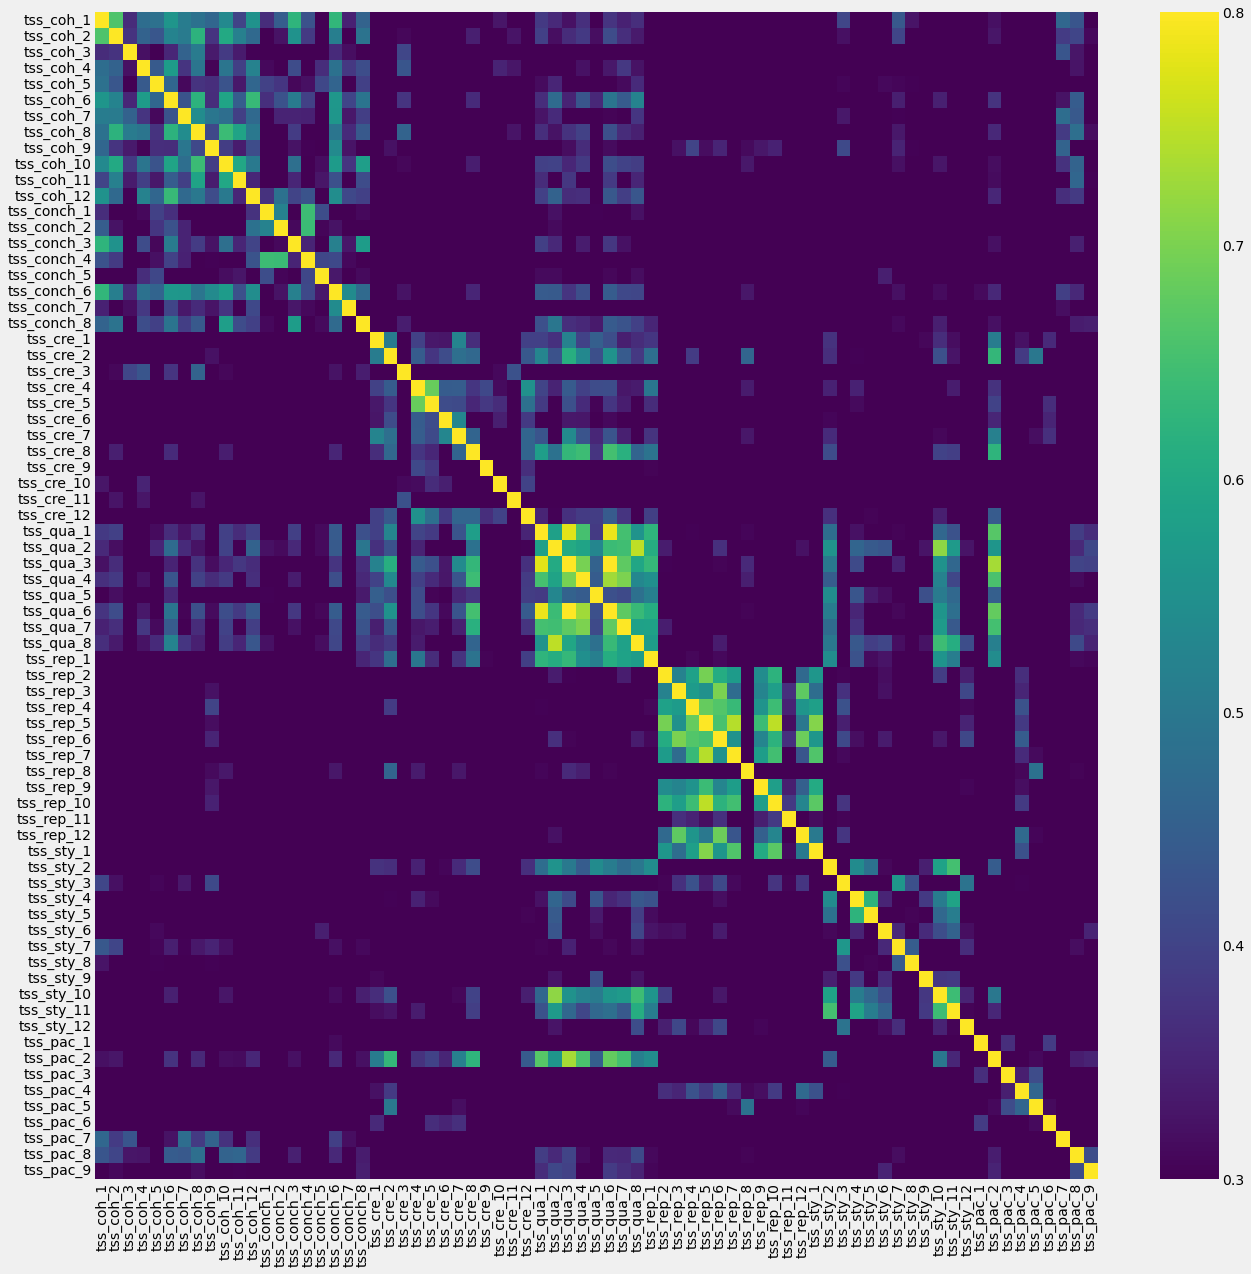

In [187]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [188]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_conch_5", "tss_conch_7", 
    "tss_cre_3", "tss_cre_9", "tss_cre_10", "tss_cre_11",
    "tss_rep_8", "tss_rep_10",
    "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_conch_5: The descriptions of characters in the story were plausible.
Correlations >= .3:
tss_coh_4      0.362796
tss_coh_5      0.405959
tss_coh_10     0.317507
tss_coh_11     0.327548
tss_conch_1    0.416267
tss_conch_8    0.313116
tss_qua_1      0.312705
tss_qua_2      0.312439
tss_qua_6      0.309263
tss_qua_8      0.317316
tss_sty_6      0.341737
tss_sty_10     0.301077

tss_conch_7: How characters in the story acted seemed implausible.
Correlations >= .3:
tss_coh_1      0.345730
tss_coh_7      0.331490
tss_coh_9      0.326142
tss_coh_12     0.407792
tss_conch_3    0.331164
tss_conch_4    0.310181
tss_conch_6    0.539865
tss_pac_7      0.318105

tss_cre_3: The plot development in the story was predictable.
Correlations >= .3:
tss_coh_3      0.404922
tss_coh_4      0.432468
tss_coh_6      0.375858
tss_coh_8      0.456968
tss_coh_10     0.308723
tss_conch_8    0.340548
tss_cre_11     0.424960

tss_cre_9: The setting of the story was original.
Correlations >= .3:
tss_cre_4     0.4

In [189]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [190]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [191]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 2.382864155210288e-25

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 51.21
('The story was fun to read.')

Excluded item tss_coh_1. VIF: 36.63
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_coh_12. VIF: 34.74
('The story lacked logic.')

Excluded item tss_cre_2. VIF: 31.94
('The story was boring.')

Excluded item tss_cre_5. VIF: 31.59
('The story was imaginative.')

Excluded item tss_qua_6. VIF: 30.69
('I liked this story.')

Excluded item tss_rep_5. VIF: 28.13
('In the story, the same things happened again and again.')

Excluded item tss_rep_12. VIF: 27.25
('Particular words were used too often in the story.')

Excluded item tss_conch_5. VIF: 26.69
('The descriptions of characters in the story were plausible.')

Excluded item tss_sty_7. VIF: 26.43
('The text was easy to understand.')

Excluded item

In [192]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.830094124083471
All item KMOs are >.6


In [193]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

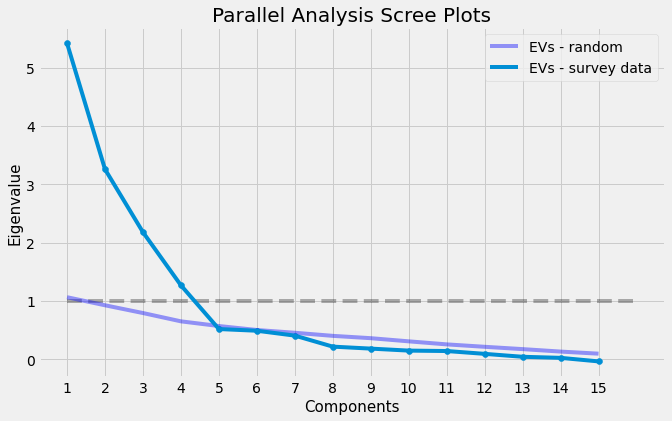

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.07				5.42
2	0.93				3.26
3	0.80				2.18
4	0.65				1.27
5	0.57				0.52
6	0.50				0.49
7	0.46				0.41
8	0.40				0.22
9	0.36				0.19
10	0.31				0.15
11	0.26				0.14
12	0.22				0.10
13	0.18				0.05
14	0.13				0.03
15	0.10				-0.03


In [194]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

In [195]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.14828877 -0.28499657  0.06252133]
 [ 0.14828877  1.         -0.05430777 -0.19589828]
 [-0.28499657 -0.05430777  1.          0.07650535]
 [ 0.06252133 -0.19589828  0.07650535  1.        ]]


In [196]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")

def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_conch_4: The way the characters were described was inconsistent.
Main (absolute) Loading: 0.3828

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3584

Fitted solution #2



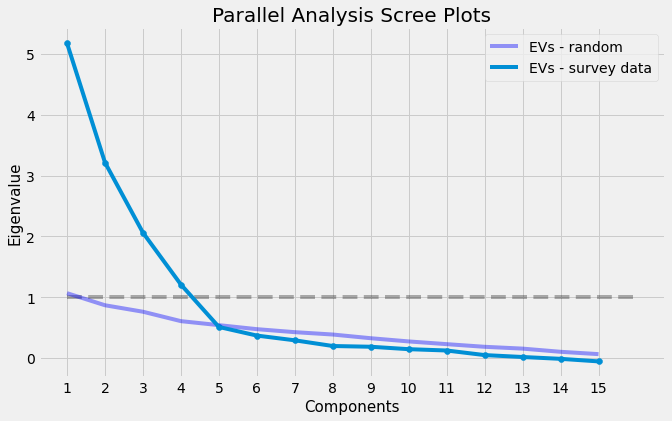

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_9: The story contained a great deal of detail.
Communality: 0.1852

Fitted solution #3



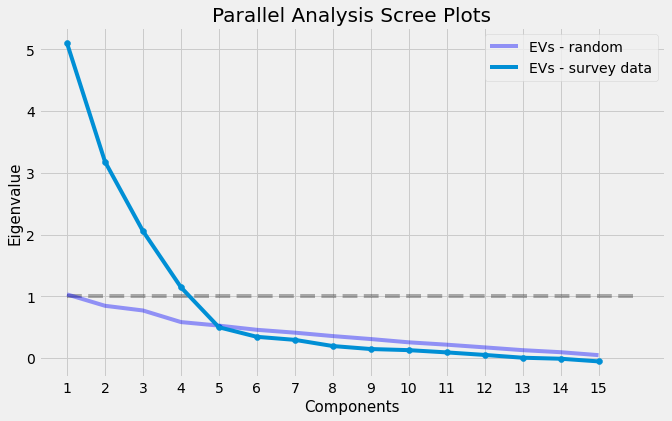

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 11 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.500408
1    0.036423
2    0.474799
3    0.062170
Name: tss_coh_9, dtype: float64

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Loadings: 
0   -0.415107
1   -0.039793
2    0.154379
3   -0.233701
Name: tss_conch_7, dtype: float64

Removed item tss_cre_3: The plot development in the story was predictable.
Loadings: 
0    0.474282
1   -0.112888
2    0.030404
3    0.296186
Name: tss_cre_3, dtype: float64

Removed item tss_cre_6: It was surprising how things turned out in the story.
Loadings: 
0   -0.117375
1    0.520027
2    0.004679
3   -0.355683
Name: tss_cre_6, dtype: float64

Removed item tss_cre_7: There were interesting twists and t

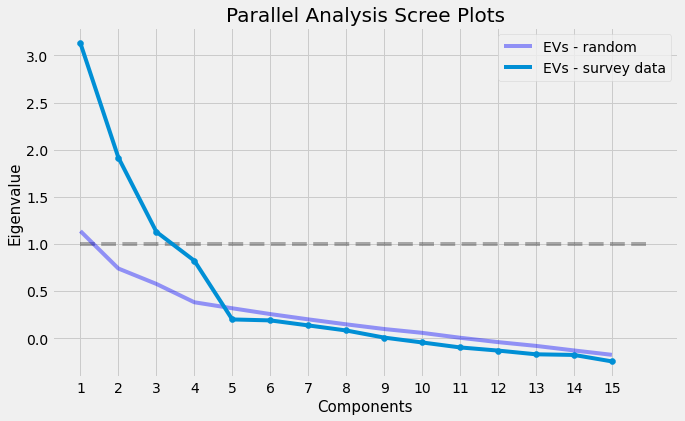

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_5: The story used complex vocabulary.
Communality: 0.1887

Fitted solution #5



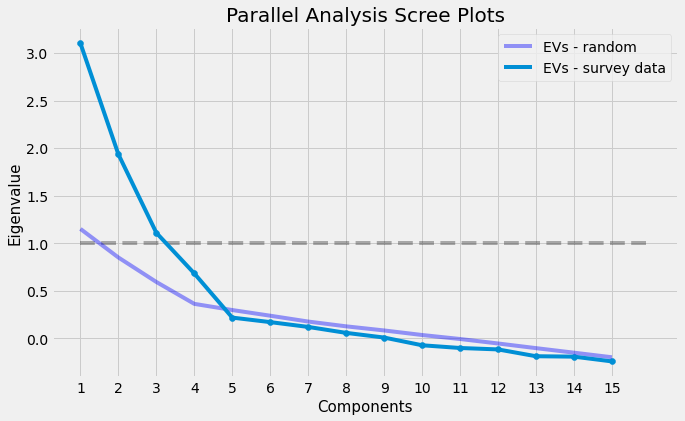

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.011387987309858004
Determinant looks good!
Overall KMO: 0.7715898074301968
Low KMO for tss_cre_12 ('The story was innovative.'): 0.5992101963994411


In [197]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [198]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

print_sorted_loadings(efa_4, items_4, load_thresh=0.32, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_2   -0.749276                    I had a hard time recognizing the thread of the story.
tss_coh_6    0.682421                                     The story felt like a coherent story.
tss_coh_11   0.662356                                              The story had a clear theme.
tss_pac_8    0.619700                      All elements of the story were relevant to the plot.
tss_conch_8  0.579597  It was easy to understand the motivation of the characters in the story.
tss_coh_3    0.538032                                   The story appeared to be a single plot.
tss_pac_7   -0.511219                  Many things seemed to be happening at once in the story. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_10  0.773469                            Characters said o

In [199]:
items_per_fac_4 = rev_items_and_return(tss_df, efa_4, items_4)

for factor_n in items_per_fac_4:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.8153, 95% CI = [0.78, 0.85]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8041
tss_coh_6: 0.7780
tss_coh_11: 0.7849
tss_conch_8: 0.7951
tss_pac_8: 0.7937
tss_coh_2_rev: 0.7715
tss_pac_7_rev: 0.8062


Internal consistency for factor 1:
Cronbachs alpha = 0.7748, 95% CI = [0.72, 0.82]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6978
tss_rep_9: 0.7048
tss_rep_10: 0.6780
tss_rep_11: 0.7916


Internal consistency for factor 2:
Cronbachs alpha = 0.6154, 95% CI = [0.52, 0.70]

Cronbach's alpha when excluding variable...
tss_pac_3: 0.4133
tss_pac_5: 0.5361
tss_pac_1_rev: 0.5862


Internal consistency for factor 3:


In [200]:
items_4_2 = copy.deepcopy(items_4)
items_4_2.remove("tss_rep_11")
items_4_2.extend(["tss_cre_1","tss_cre_2","tss_cre_4","tss_cre_5","tss_cre_8","tss_cre_10","tss_cre_11"])
items_4_2.extend(["tss_pac_2","tss_pac_4"])

In [201]:
items_4_2 = reduce_multicoll(
    tss_df, items_4_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 7.995461083534575e-05

Determinant is > .00001. No issues with multicollinearity detected.


Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 6 items with high cross loading. Excluding them for next analysis.

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0    0.486586
1    0.084160
2   -0.380658
3   -0.083852
Name: tss_cre_1, dtype: float64

Removed item tss_cre_2: The story was boring.
Loadings: 
0   -0.530899
1   -0.240502
2    0.495168
3    0.144205
Name: tss_cre_2, dtype: float64

Removed item tss_cre_8: I was intrigued by the plot.
Loadings: 
0    0.515557
1    0.374621
2   -0.179735
3   -0.051694
Name: tss_cre_8, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0    0.473630
1   -0.376409
2   -0.014637
3    0.085361
Name: tss_cre_10, dtype: float64

Removed item tss_pac_2: The story was exciting to read.
Loadings: 
0    0.568285
1    0.397735
2   -0.314527
3   -0.050378
Name: tss_pac_2, dtype: float

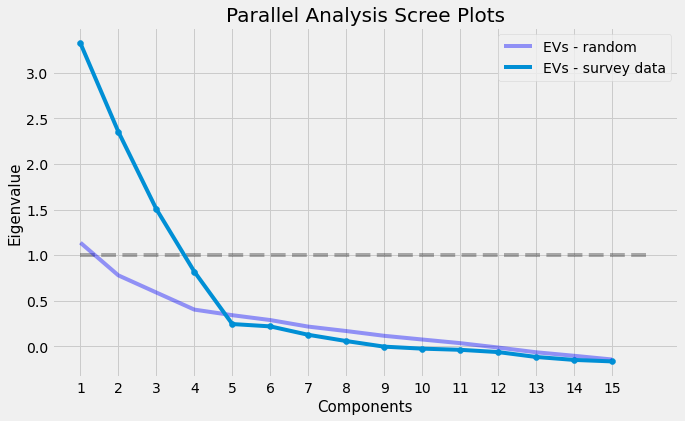

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0031641578908670844
Determinant looks good!
Overall KMO: 0.7880361711343741
All item KMOs are >.6


In [202]:
four_facs_2 = iterative_efa(tss_df, items_4_2, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [203]:
efa_4_2 = four_facs_2[0]
items_4_2 = four_facs_2[1]

print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_2   -0.750915                    I had a hard time recognizing the thread of the story.
tss_coh_6    0.681755                                     The story felt like a coherent story.
tss_coh_11   0.664128                                              The story had a clear theme.
tss_pac_8    0.618061                      All elements of the story were relevant to the plot.
tss_conch_8  0.567837  It was easy to understand the motivation of the characters in the story.
tss_coh_3    0.549026                                   The story appeared to be a single plot.
tss_pac_7   -0.510532                  Many things seemed to be happening at once in the story.
tss_cre_11   0.432831                              The plot was typical for this kind of story. 

Relevant loadings for factor 1
                   1                                   descr
tss_cre_4  

In [204]:
items_per_fac_4_2 = rev_items_and_return(tss_df, efa_4_2, items_4_2)

for factor_n in items_per_fac_4_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8177, 95% CI = [0.78, 0.85]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8042
tss_coh_6: 0.7830
tss_coh_11: 0.7882
tss_conch_8: 0.7987
tss_pac_8: 0.7961
tss_cre_11: 0.8153
tss_coh_2_rev: 0.7771
tss_pac_7_rev: 0.8081


Internal consistency for factor 1:
Cronbachs alpha = 0.7836, 95% CI = [0.73, 0.83]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.8013
tss_cre_12: 0.7392
tss_cre_4: 0.6733
tss_cre_5: 0.7008


Internal consistency for factor 2:
Cronbachs alpha = 0.7916, 95% CI = [0.74, 0.84]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7312
tss_rep_9: 0.7320
tss_rep_10: 0.6878


Internal consistency for factor 3:
Cronbachs alpha = 0.6154, 95% CI = [0.52, 0.70]

Cronbach's alpha when excluding variable...
tss_pac_3: 0.4133
tss_pac_5: 0.5361
tss_pac_1_rev: 0.5862




In [205]:
items_per_fac_4_2[1].remove("tss_cre_9")
items_per_fac_4_2

{0: ['tss_coh_3',
  'tss_coh_6',
  'tss_coh_11',
  'tss_conch_8',
  'tss_pac_8',
  'tss_cre_11',
  'tss_coh_2_rev',
  'tss_pac_7_rev'],
 1: ['tss_cre_12', 'tss_cre_4', 'tss_cre_5'],
 2: ['tss_rep_3', 'tss_rep_9', 'tss_rep_10'],
 3: ['tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev']}

In [206]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_4_2[0]].isna().sum(axis=1) <= 3
mask_suff_data_cre = tss_df[items_per_fac_4_2[1]].isna().sum(axis=1) <= 2
mask_suff_data_rep = tss_df[items_per_fac_4_2[2]].isna().sum(axis=1) <= 1
mask_suff_data_pac = tss_df[items_per_fac_4_2[3]].isna().sum(axis=1) <= 1
tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_4_2[0]].mean(axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_4_2[1]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_4_2[2]].mean(axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_4_2[3]].mean(axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [207]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,pass_qual_1,pass_qual_2,tss_coh_2_rev,tss_pac_7_rev,tss_pac_1_rev,tss_coh,tss_cre,tss_rep,tss_pac,tss_avoid_rep


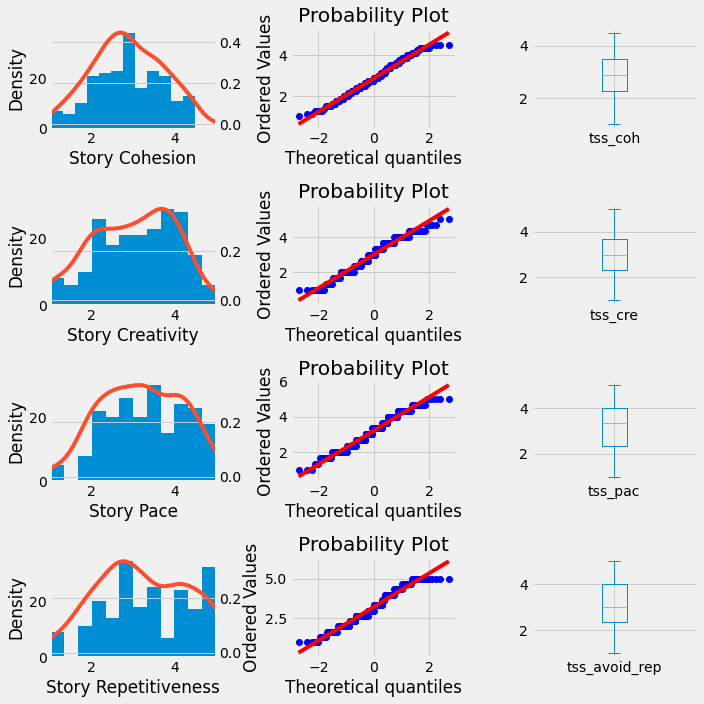

In [208]:
# Check scale distributions
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Story Repetitiveness")
ax4.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])

fig.tight_layout()
plt.show()

In [209]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac
tss_coh,1.000000,0.079251,0.161595,-0.123374
tss_cre,0.079251,1.000000,0.148873,0.193327
tss_avoid_rep,0.161595,0.148873,1.000000,0.126649
tss_pac,-0.123374,0.193327,0.126649,1.000000


<Figure size 720x720 with 0 Axes>

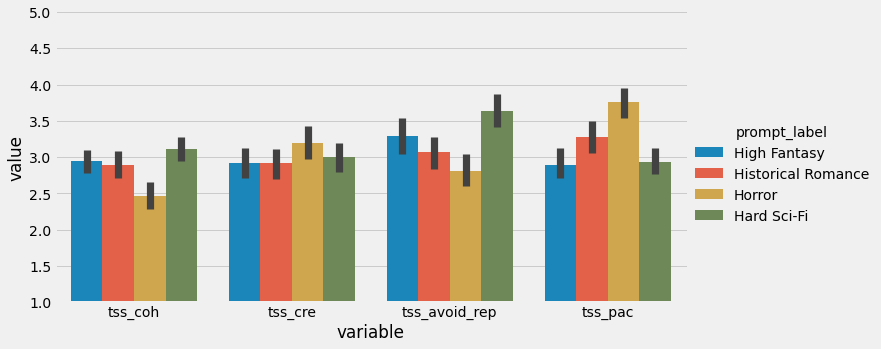

In [210]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

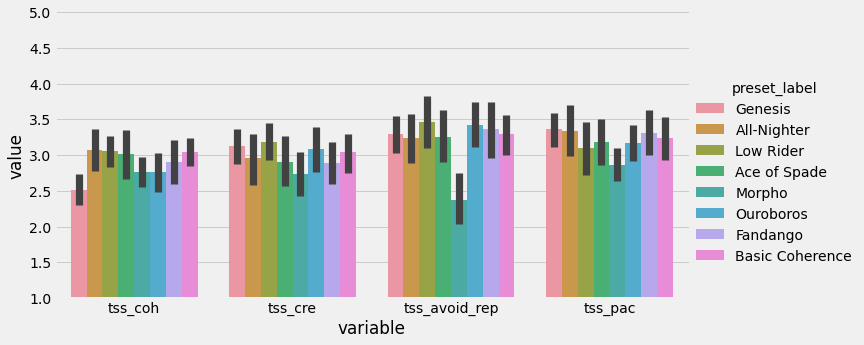

In [211]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_cre'>

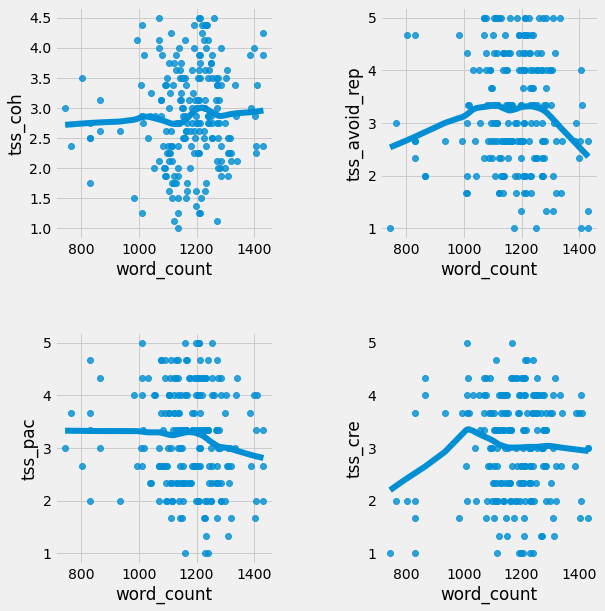

In [212]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[1, 1])

In [213]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0565    RMSE: 0.8176
Model performance for quadratic model predicting tss_coh:
r-square: -0.0635    RMSE: 0.8196
Model performance for cubic model predicting tss_coh:
r-square: -0.0826    RMSE: 0.8267

Model performance for linear model predicting tss_cre:
r-square: -0.0642    RMSE: 0.9585
Model performance for quadratic model predicting tss_cre:
r-square: -0.0628    RMSE: 0.9549
Model performance for cubic model predicting tss_cre:
r-square: -0.0604    RMSE: 0.9535

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0649    RMSE: 1.0720
Model performance for quadratic model predicting tss_avoid_rep:
r-square: -0.0548    RMSE: 1.0608
Model performance for cubic model predicting tss_avoid_rep:
r-square: -0.0478    RMSE: 1.0592

Model performance for linear model predicting tss_pac:
r-square: -0.1320    RMSE: 0.9501
Model performance for quadratic model predicting tss_pac:
r-square: -0.1385    RMSE

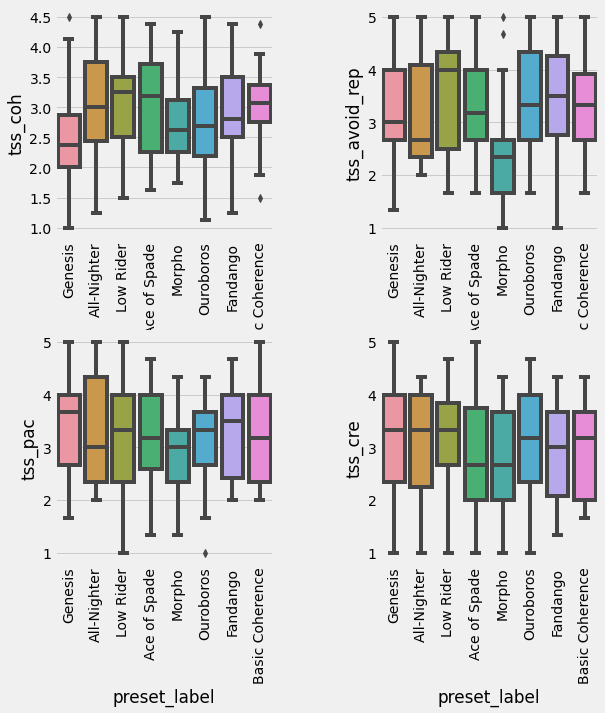

In [214]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

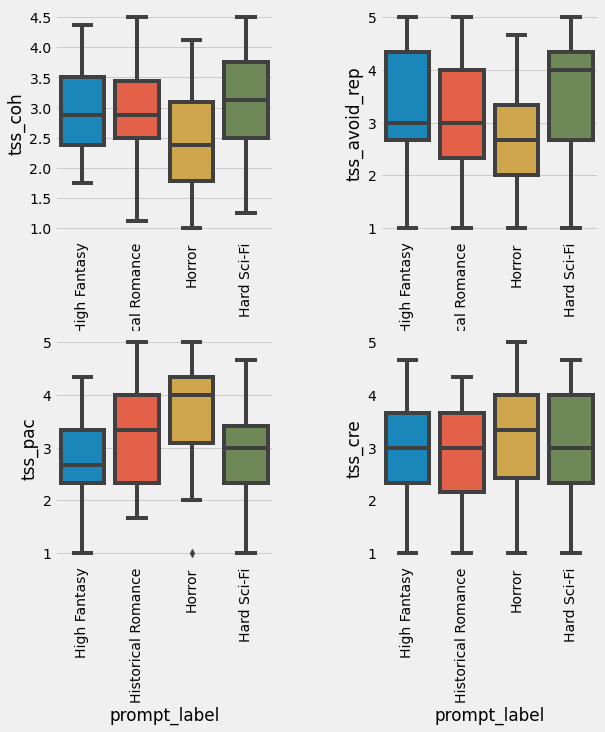

In [215]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

In [216]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    
    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(q1,q3,iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [217]:
## Outliers for Presets
# Outliers Coherence
print("Exterme outliers on tss_coh, Genesis preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Genesis"], "tss_coh")
print("\nExterme outliers on tss_coh, Basic Coherence preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_coh")
# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
# Outliers pace
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_pac")

## Outliers for Prompts
print("\nExterme outliers on tss_pac, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")

Exterme outliers on tss_coh, Genesis preset
25th Percentile (Q1): 2.00
75th Percentile (Q3): 2.88
IQR: 0.88
Will count cases as outlier with values less than -0.62 or more than 5.50.
With these criteria there are no outlier in the data

Exterme outliers on tss_coh, Basic Coherence preset
25th Percentile (Q1): 2.75
75th Percentile (Q3): 3.38
IQR: 0.62
Will count cases as outlier with values less than 0.88 or more than 5.25.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.67
75th Percentile (Q3): 2.67
IQR: 1.00
Will count cases as outlier with values less than -1.33 or more than 5.67.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouroboros preset
25th Percentile (Q1): 2.67
75th Percentile (Q3): 3.67
IQR: 1.00
Will count cases as outlier with values less than -0.33 or more than 6.67.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Horror prompt
2

In [218]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15,15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(vars_li), len(groups_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li,vars_li):
        stats.probplot(df[df[group_label]==group][var], dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - "+ var)
        if x < (len(groups_li)-1):
            x += 1
        else:
            x = 0
            y += 1

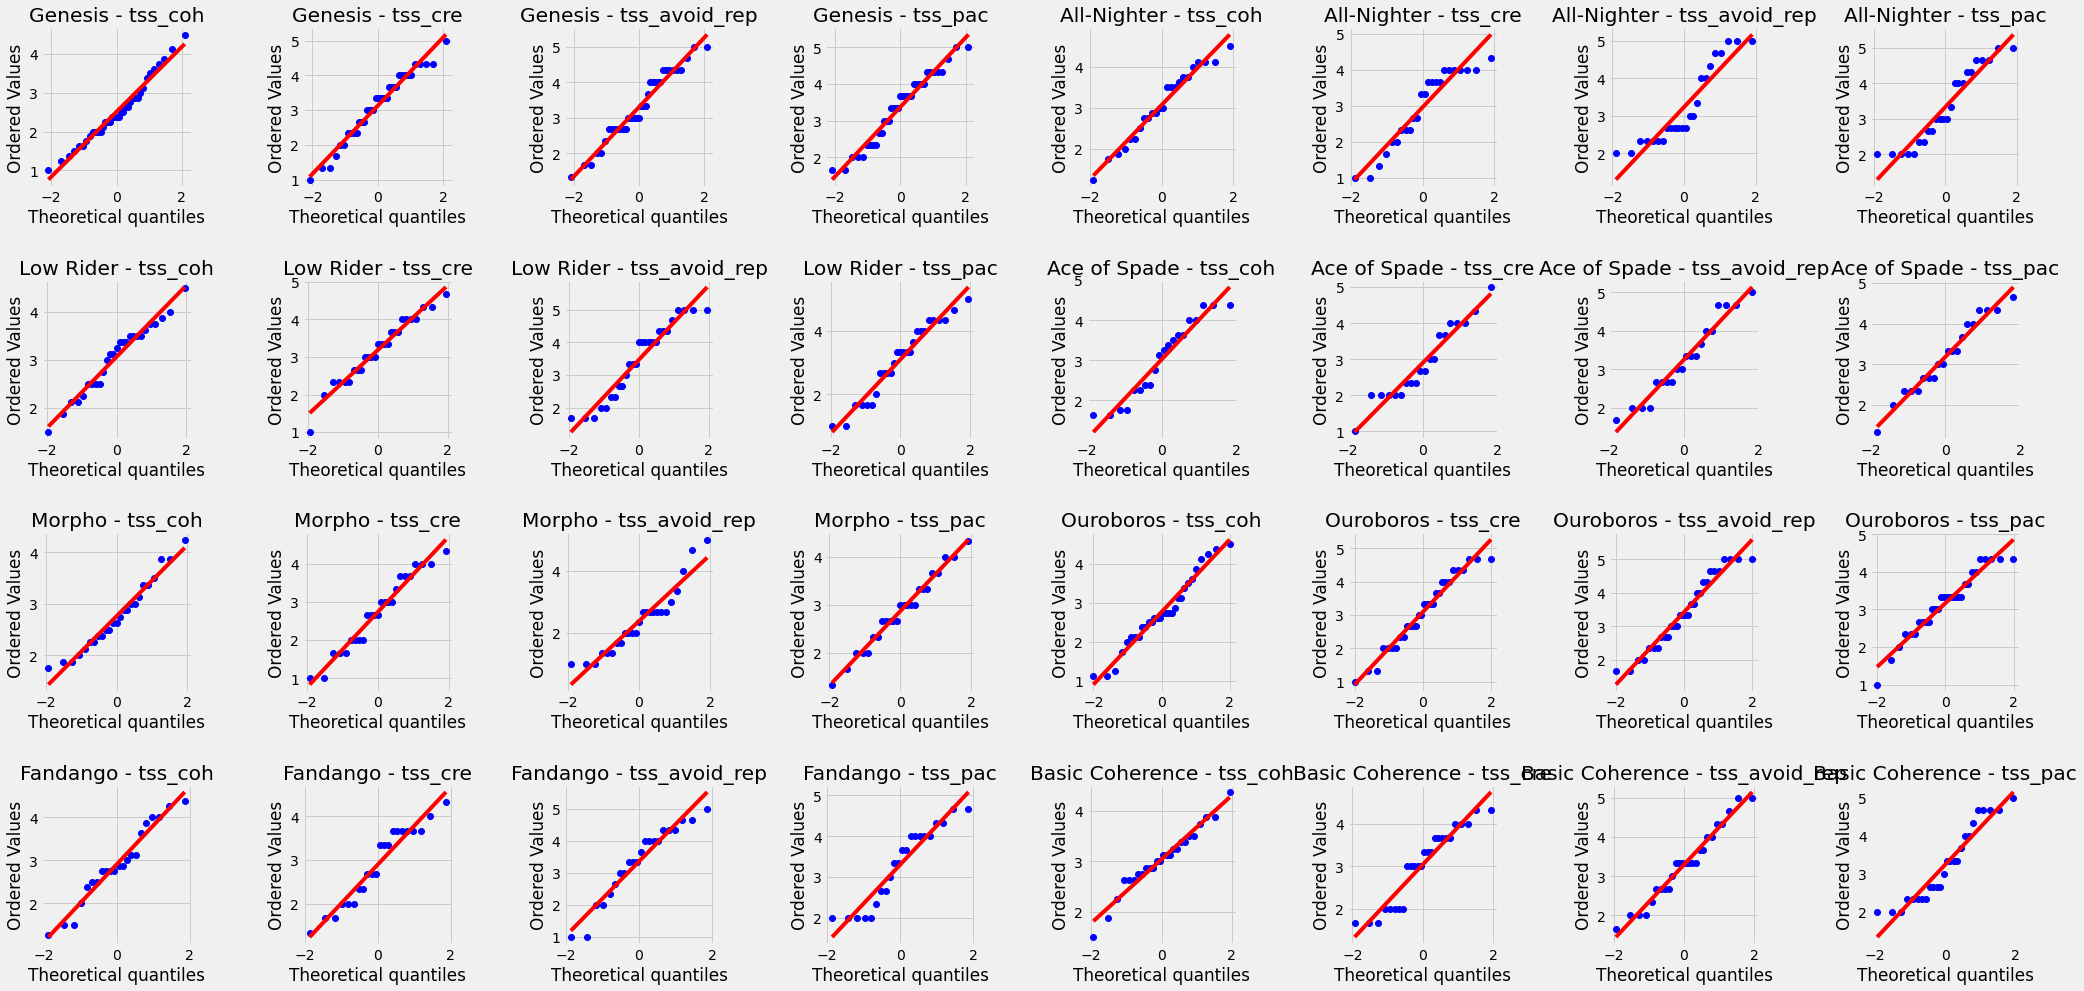

In [219]:
qqs_over_groups_and_vars(tss_df, "preset_label", outcome_li, size = (30,15))

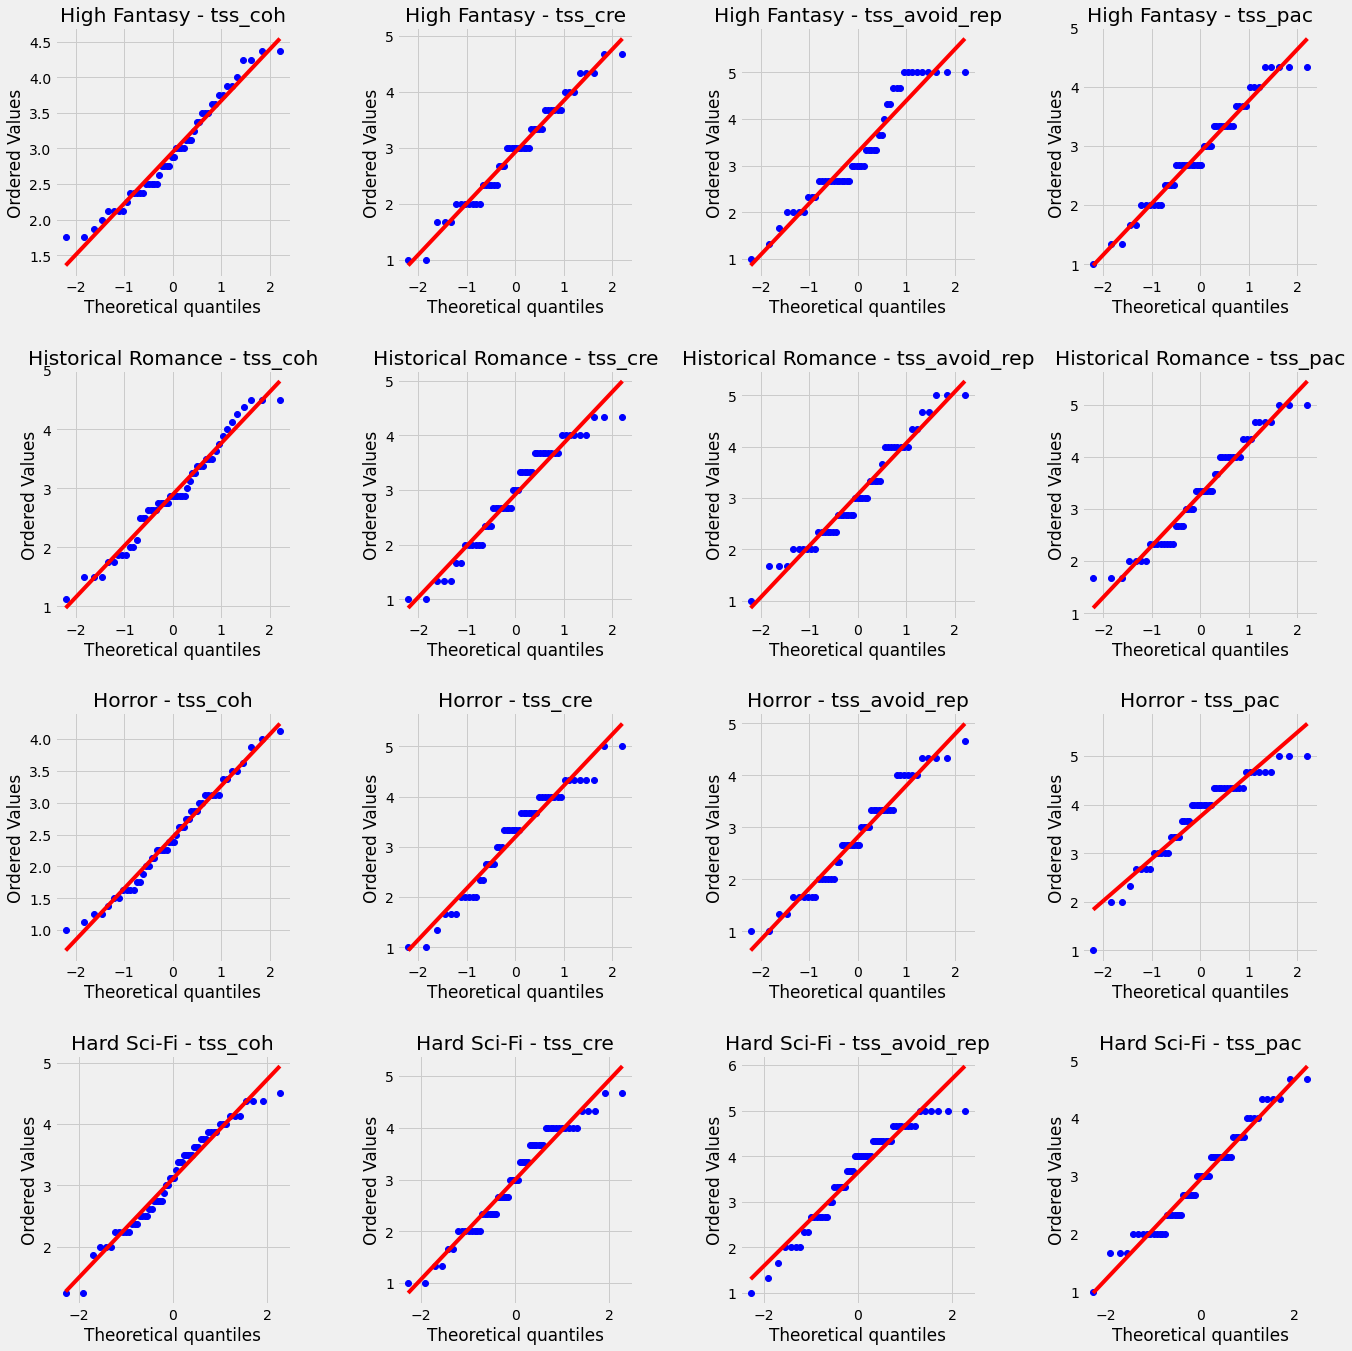

In [220]:
qqs_over_groups_and_vars(tss_df, "prompt_label", outcome_li, size = (20,20))

In [ ]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {}, coefficient of sample size variation is {:.2f}, variance ratio is {}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [ ]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_df)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_df)
    print("\n")

In [ ]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_df).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_df).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))
    
    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")
    
    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7], outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome + " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]
    
    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10], outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome + " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

In [ ]:
params_df.index = params_df.index.str.replace(r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace("90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_df["preset_label"].unique())
prompts_li = list(tss_df["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]
    
    cols_order.extend([outcome, outcome + " p-value", outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [ ]:
params_df

In [ ]:
tss_df["preset_label"].value_counts()

In [ ]:
labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each preset with an empty list as value for each
marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
yerr_dict = {preset: [] for preset in params_df[1:8].index}
#colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
    marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(labels)) # label locations
width = 0.35 # width of bars

plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
        yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")

plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
        yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")

i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
plt.xticks(x, labels, fontsize = 16)

plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
leg = plt.gca().get_legend()
plt.grid(False)
#plt.title("Genesis & Low Rider")
#figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

In [ ]:
labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for preset, outcome in itertools.product(["Genesis", "Ouroboros"], outcome_li):
    marginal_means_dict[outcome].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[outcome].append(params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"])) # label locations
width = 0.2 # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr = yerr_dict["tss_coh"], label = "Coherence", color = "tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
         yerr = yerr_dict["tss_cre"], label = "Creativity", color = "tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
         yerr = yerr_dict["tss_avoid_rep"], label = "Avoiding Repetition", color = "tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
         yerr = yerr_dict["tss_pac"], label = "Pace", color = "tab:orange")

i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+width], [grand_mean, grand_mean], '--', color = "black", alpha = 0.7)
    ax = plt.plot([pos+1, pos+width+1], [grand_mean, grand_mean], '--', color = "black", alpha = 0.7)
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += width
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
plt.xticks(x, ["Genesis", "Ouroboros"], fontsize = 16)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon=False, fontsize = 16, loc='upper center', ncol = 3, bbox_to_anchor = (0.55,1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
#figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_our_v2.png', bbox_inches="tight")

In [ ]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for outcome in outcome_li:
    genesis_marginal_means.append(params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])
    

figure = plt.figure(figsize=(10, 5))

plt.bar(["Coherence", "Creativity", "Avoiding Repitition", "Pace"], genesis_marginal_means, yerr = genesis_yerr,
       color = colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean], '--', color = colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [ ]:
tss_df[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre",
        "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

In [ ]:
items_descr[["tss_cre_4","tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

In [ ]:
qual = tss_df.groupby('preset_label').mean()[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_2")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_2"])
plt.xticks(rotation=45)

In [ ]:
marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p", 
                               "tss_avoid_rep adj_p", "tss_pac adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[["Genesis", "Ouroboros"], outcome] = marg_means_df.loc[["Genesis", "Ouroboros"], outcome].apply(
    lambda x: marg_means_df.loc["Intercept", outcome]+x)
    
marg_means_df.rename(index = {"Intercept": "Grand Mean"}, inplace = True)
marg_means_df.columns = marg_means_df.columns.str.replace("tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_cre", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")

In [ ]:
marg_means_df

In [ ]:
radar_df = marg_means_df.loc[["Genesis", "Ouroboros"], [["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]]
radar_df.shape

In [ ]:
from math import pi

radar_df = marg_means_df.loc[["Genesis", "Ouroboros"], ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]]

# number of variable
categories = list(radar_df)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2,3,4], ["2", "3", "4"], color="grey", size=7)
plt.ylim(1,5)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=radar_df.iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Genesis")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=radar_df.iloc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Ouroboros")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

In [ ]:
marg_means_df.to_excel("est_marg_means_presets.xlsx")